In [1]:
from datetime import datetime
from dotenv import load_dotenv
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout


Using TensorFlow backend.
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tenso

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
load_dotenv()
path = Path(os.getenv('PATH_DATASET1.2')).joinpath('usertracks_csv')

In [3]:
track_names = np.genfromtxt(path.joinpath('track_names.csv'), delimiter=',', dtype='U')
categories = np.genfromtxt(path.joinpath('label_categories.csv'), delimiter=',', dtype='U')

In [54]:
categories

array(['Classic progressive', 'Deep house', 'House-Trance',
       'Our old school trance', 'Our old school trance 138',
       'Our old school trance 2', 'Progressive 1', 'Progressive 2',
       'Progressive 3', 'Progressive 4', 'Progressive 5',
       'Progressive House', 'That familiar trance'], dtype='<U25')

In [4]:
tot_num = len(track_names)
categ = len(categories)
print(' Total number of tracks:', tot_num)
print(' Total number of categories/playlists:', categ)

 Total number of tracks: 372
 Total number of categories/playlists: 13


In [5]:
# read_csv files and create a list of data arrays and data labels
path_ = path.joinpath('track_arrays')
data_arr = [np.genfromtxt(path_.joinpath('track_inp_{}.csv'.format(i)), delimiter=',') for i in range(tot_num)]
path_ = path.joinpath('track_labels')
data_lab = [np.genfromtxt(path_.joinpath('track_lab_{}.csv'.format(i)), delimiter=',') for i in range(tot_num)]

In [6]:
print('Sample track:' , track_names[120])
print('Input array:' , data_arr[120])
print('Label array:' , data_lab[120])
print('Label category: ', categories[data_lab[120]>0])

Sample track: I Won't Fall (Progressive Mix) [feat. Stine Grove]_Aur
Input array: [ 0.522  1.     0.202 ...  0.178  0.366 -0.253]
Label array: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label category:  ['Our old school trance']


In [7]:
# zip track names with input arrays before shuffling and splitting train/test sets
data = [i for i in zip(track_names, data_arr)]

In [8]:
data_train, data_test, y_train, y_test = train_test_split(data, data_lab, test_size = 0.25, stratify=data_lab, random_state=17)

In [9]:
'''
data_val = data_train[-50:]
y_val = y_train[-50:]
data_train = data_train[:-50]
y_train = y_train[:-50]
'''

'\ndata_val = data_train[-50:]\ny_val = y_train[-50:]\ndata_train = data_train[:-50]\ny_train = y_train[:-50]\n'

In [10]:
print('Number of tracks in training', len(data_train))
#print('Number of tracks in validation:', len(data_val))
print('Number of tracks in testing:', len(data_test))

Number of tracks in training 279
Number of tracks in testing: 93


In [11]:
x_train = [x[1] for x in data_train]
track_train = [x[0] for x in data_train]
#x_val = [x[1] for x in data_val]
#track_val = [x[0] for x in data_val]
x_test = [x[1] for x in data_test]
track_test = [x[0] for x in data_test]

In [12]:
# cast lists to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [24]:
def create_classifier(base_model, nodes, dropout=True, new_idx=True):
    
    def dense_layer(x, nodes_, activation=tf.nn.leaky_relu, dropout=dropout, name_idx=None):
    
        # define a dense layer section
        x = Dense(nodes_, name='dense_{}'.format(name_idx))(x)
        x = Activation(activation, name='act_{}'.format(name_idx))(x)
        x = BatchNormalization(name='bn_{}'.format(name_idx))(x)
        if dropout:
            x = Dropout(0.3, name='dropout_{}'.format(name_idx))(x)
            
        return x
    
    # classes/playlists in the dataset
    classes = len(y_train[0])
    
    if new_idx:
        # create new index for naming layers
        idx = int(base_model.layers[-1].name[-1]) + 1
    else:
        idx = 0
    # Create classifier by adding dense layers to the base model
    x = dense_layer(base_model.layers[-1].output, nodes[0], activation='tanh', name_idx=idx + 0 )
   
    for i in range(1, len(nodes)):
        x = dense_layer(x, nodes[i], name_idx=idx + i)
    
    # Set nodes of last dense layer as number of classes
    outputs = Dense(classes, activation='softmax', name='dense_{}'.format(idx + len(nodes)))(x)
    
    # create model
    model = Model(inputs=base_model.input, outputs=outputs, name='classifier')
    
    return  model

In [25]:
tf.keras.backend.clear_session()

In [26]:
# Load encoder model
loaded_enc = keras.models.load_model(filepath=Path(os.getenv('PATH_MODELS')).joinpath('encoder'))
    
# Freeze and rename all the layers
for layer in loaded_enc.layers[:]:
    layer.trainable = False
    layer._name = str('enc_') + layer.name
    
# Set number of units/nodes for the dense layers added in the classifier

In [27]:

inputlength = 2400
inputs = Input(shape=(inputlength,), name='base_input')
x = Dense(800, name='base_dense')(inputs)
x = Activation(tf.nn.leaky_relu, name='base_act')(x)
outputs = BatchNormalization(name='base_bn')(x)

basemodel = Model(inputs, outputs, name='base_model')

In [70]:
nodes = [800, 400, 200, 100, 200, 100, 50, 25]
#cls_nn = create_classifier(loaded_enc, nodes, dropout=True)
cls_nn = create_classifier(basemodel, nodes, dropout=True, new_idx=False)

In [71]:
#cls_nn.summary()

In [72]:
cls_nn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [73]:
BATCH_SIZE = 16
TRAIN_STEPS_PER_EPOCH = np.ceil(len(x_train)/ BATCH_SIZE)       #np.ceil(TRAIN_COUNT/BATCH_SIZE)
#VAL_STEPS_PER_EPOCH = np.ceil(len(x_val)/BATCH_SIZE)        #np.ceil(VAL_COUNT/BATCH_SIZE)
TEST_STEPS = len(x_test)
EPOCHS = 500

In [86]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)
result = cls_nn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              verbose=0,
              epochs=EPOCHS,
              validation_split=0.2,
              callbacks=[callback])

In [87]:
print(len(result.history['loss']))
result.history['val_acc'][::15]

88


[0.10714286, 0.19642857, 0.14285715, 0.17857143, 0.14285715, 0.25]

In [88]:
cls_nn.evaluate(x_test,y_test)

93/93 [==============================] - 0s 355us/sample - loss: 4.8929 - acc: 0.2151


[4.892929912895284, 0.21505377]

In [59]:
categories

array(['Classic progressive', 'Deep house', 'House-Trance',
       'Our old school trance', 'Our old school trance 138',
       'Our old school trance 2', 'Progressive 1', 'Progressive 2',
       'Progressive 3', 'Progressive 4', 'Progressive 5',
       'Progressive House', 'That familiar trance'], dtype='<U25')

In [60]:
ord_categ = ['Deep house', 'Progressive House', 'House-Trance', 'That familiar trance', 'Classic progressive',
            'Our old school trance', 'Our old school trance 2', 'Our old school trance 138', 'Progressive 1',
            'Progressive 2', 'Progressive 3', 'Progressive 4', 'Progressive 5']

In [89]:
pred = [categories[np.argmax(x)] for x in cls_nn.predict(x_test)]
target = [categories[np.argmax(x)] for x in y_test]
comp = [x for x in zip(track_test, pred,target)]
target_counts = [(x, target.count(x)) for x in set(target)]
pred_counts = [(x, pred.count(x)) for x in set(pred)]
con_mat =confusion_matrix(target, pred, labels=ord_categ) 
con_mat_df = pd.DataFrame(con_mat, index = ord_categ, columns = ord_categ)

In [90]:
target_counts

[('Deep house', 7),
 ('Progressive 2', 7),
 ('Progressive 1', 4),
 ('That familiar trance', 12),
 ('Our old school trance 138', 5),
 ('Our old school trance 2', 6),
 ('Progressive 4', 8),
 ('Our old school trance', 9),
 ('Progressive 5', 4),
 ('Progressive 3', 5),
 ('Progressive House', 5),
 ('House-Trance', 12),
 ('Classic progressive', 9)]

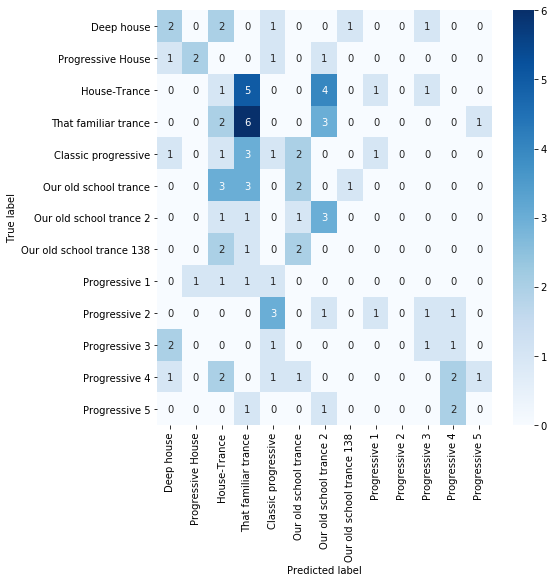

In [91]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [92]:
comp

[('Dawn - Original Mix_Yas', 'Deep house', 'Progressive 4'),
 ('Solidus_Feh', 'Our old school trance 2', 'House-Trance'),
 ('We Are True (Radio Edit)_Mik', 'Progressive 1', 'Classic progressive'),
 ('Back To Mine - Original Mix_Emb', 'Progressive 4', 'Progressive 4'),
 ('Ulvetanna_Pro', 'Our old school trance', 'Our old school trance 2'),
 ('The Bridge - Anjunadeep 07 Mix_Jod',
  'Progressive House',
  'Progressive House'),
 ('Odyssey - Original Mix_Vad',
  'That familiar trance',
  'Our old school trance'),
 ('Now We Are Talking_Orj', 'That familiar trance', 'Our old school trance 2'),
 ('Tokyo Night Train - RMX_Cla', 'Progressive House', 'Progressive 1'),
 ('Something Useful - Lesh Remix_Phr', 'Deep house', 'Progressive House'),
 ('Your Perspective feat. KnottRudy - Infinity State Remix_Phr',
  'Progressive 4',
  'Progressive 5'),
 ('Lights_Eri', 'Classic progressive', 'Progressive 4'),
 ('Alba - Sundriver Remix_Dru', 'Classic progressive', 'Progressive 3'),
 ('Hypnotised_Orb', 'Prog

In [58]:
'''
y_pred = np.array([np.argmax(x) for x in cls_nn.predict(x_test)])
y_true = np.array([np.argmax(x) for x in y_test])
con_mat =confusion_matrix(y_true, y_pred, labels=categories) 
con_mat_df = pd.DataFrame(con_mat, index = categories, columns = categories)
'''

'\ny_pred = np.array([np.argmax(x) for x in cls_nn.predict(x_test)])\ny_true = np.array([np.argmax(x) for x in y_test])\ncon_mat =confusion_matrix(y_true, y_pred, labels=categories) \ncon_mat_df = pd.DataFrame(con_mat, index = categories, columns = categories)\n'